In [1]:
using LinearAlgebra, Distributions, Plots, Random, Zygote, MLDatasets, ProgressMeter

In [2]:
include("simple_nn.jl");

In [3]:
Random.seed!(69420)

TaskLocalRNG()

# XOR Problem

In [4]:
data = [
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
]

targets = [
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0]
];

In [5]:
setup = [
    DenseLayer((2, 2), sigmoid_activation),
    DenseLayer((2, 2), sigmoid_activation)
]

xor_net = CreateNetwork(setup, datatype=Float32, init_distribution=Normal());

In [6]:
OptimizerSetup!(xor_net, GradientDescentOptimizer!, learning_rate=0.01)

Dict{String, Any} with 3 entries:
  "optimizer"      => GradientDescentOptimizer!
  "optimizer_name" => "GradientDescentOptimizer!"
  "learning_rate"  => 0.01

In [7]:
epochs = 250

loss = 0.0
losses = []

cross_entropy_loss(x_in, y_val) = -sum(y_val .* log.(Forward(xor_net, x_in)))

for epoch in 1:epochs
    for (i, input) in enumerate(data)
        x_in = convert(Vector{Float32}, input)
        y_val = targets[i]
        
        pred = Forward(xor_net, x_in)
        loss = cross_entropy_loss(x_in, y_val)
        
        Backward!(xor_net, cross_entropy_loss, x_in, y_val)
        
        if epoch % 50 == 0 && i == length(targets)
            println("Epoch $epoch\tPred: $(round(maximum(pred), digits=4))\tTarget: $(maximum(y_val))\tloss: $(round(loss, digits=4))")
        end
    end
    push!(losses, loss)
end

preds = round.(maximum.([Forward(xor_net, convert(Vector{Float32}, x)) for x in data]))
passed = preds .== convert(Vector{Float32}, maximum.(targets))

println("\n$(sum(passed))/4 tests passed | Accuracy $(100 * sum(passed) / length(targets))%")

Epoch 50	Pred: 0.7142	Target: 1.0	loss: 0.8478
Epoch 100	Pred: 0.7681	Target: 1.0	loss: 0.5518
Epoch 150	Pred: 0.8103	Target: 1.0	loss: 0.3888
Epoch 200	Pred: 0.8428	Target: 1.0	loss: 0.2921
Epoch 250	Pred: 0.8681	Target: 1.0	loss: 0.2302

4/4 tests passed | Accuracy 100.0%


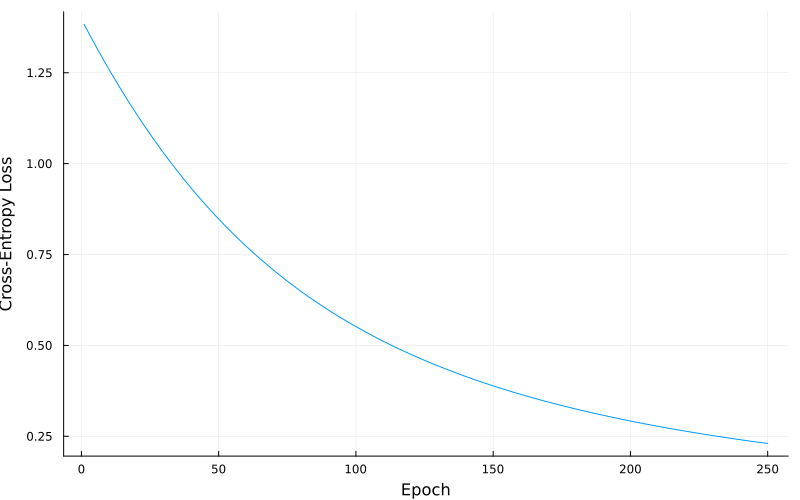

In [8]:
plot(losses, xlabel="Epoch", ylabel="Cross-Entropy Loss", label="", size=(800,500))

## Comparing Optimizers

In [9]:
optimizers = [
    GradientDescentOptimizer!, 
    MomentumOptimizer!, 
    RMSpropOptimizer!,
    AdamOptimizer!
]

xor_networks = [CreateNetwork(setup, datatype=Float32, init_distribution=Normal()) for _ in 1:length(optimizers)]

for (i, opt) in enumerate(optimizers)
    OptimizerSetup!(xor_networks[i], opt)
end

In [10]:
loss = []
losses = []

loss_funcs = [
    (x_in, y_val) -> -sum(y_val .* log.(Forward(net, x_in))) for net in xor_networks
]

for epoch in 1:epochs
    for (i, input) in enumerate(data)
        x_in = convert(Vector{Float32}, input)
        y_val = targets[i]
        
        loss = []
        
        for i in 1:length(optimizers)
            push!(loss, loss_funcs[i](x_in, y_val))
            Backward!(xor_networks[i], loss_funcs[i], x_in, y_val)
        end
    end
    push!(losses, loss)
end

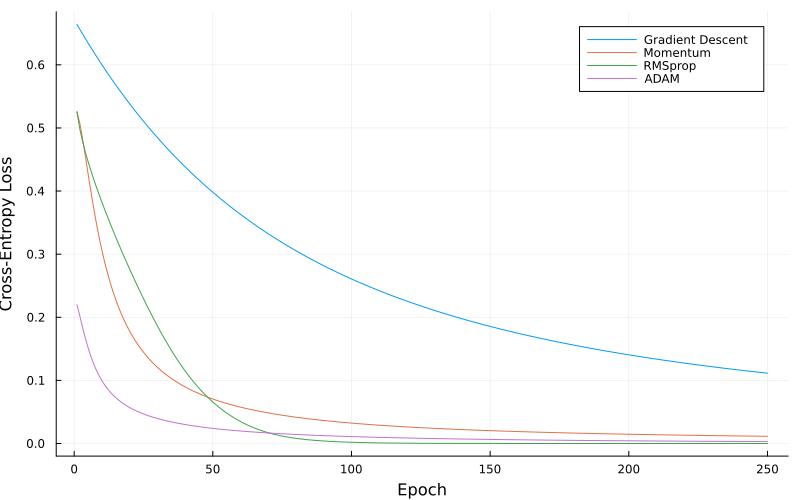

In [11]:
loss_gd = [loss[1] for loss in losses]
loss_mgd = [loss[2] for loss in losses]
loss_rms = [loss[3] for loss in losses]
loss_adam = [loss[4] for loss in losses]

plot(loss_gd, xlabel="Epoch", ylabel="Cross-Entropy Loss", label="Gradient Descent", size=(800,500))
plot!(loss_mgd, label="Momentum")
plot!(loss_rms, label="RMSprop")
plot!(loss_adam, label="ADAM")

# MNIST

In [12]:
train_x, train_y = MNIST.traindata()
train_x = Float32.(train_x)

test_x, test_y = MNIST.testdata()
test_x = Float32.(test_x);

In [13]:
# helper functions
flatten(matrix) = vcat(matrix...)

function one_hot_encoding(target)
    return Float32.(target .== collect(0:9))
end

one_hot_encoding (generic function with 1 method)

In [14]:
mnist_network = CreateNetwork([
    DenseLayer((784, 128), sigmoid_activation),
    DenseLayer((128, 64), sigmoid_activation),
    DenseLayer((64, 10), softmax_activation)
], datatype=Float32, init_distribution=Normal())

OptimizerSetup!(mnist_network, AdamOptimizer!)

Dict{String, Any} with 10 entries:
  "biases_m"       => [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  "biases_v"       => [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  "optimizer"      => AdamOptimizer!
  "decay_2"        => 0.999
  "optimizer_name" => "AdamOptimizer!"
  "epsilon"        => 1.0e-8
  "weights_v"      => [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "step_size"      => 0.01
  "weights_m"      => [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "decay_1"        => 0.9

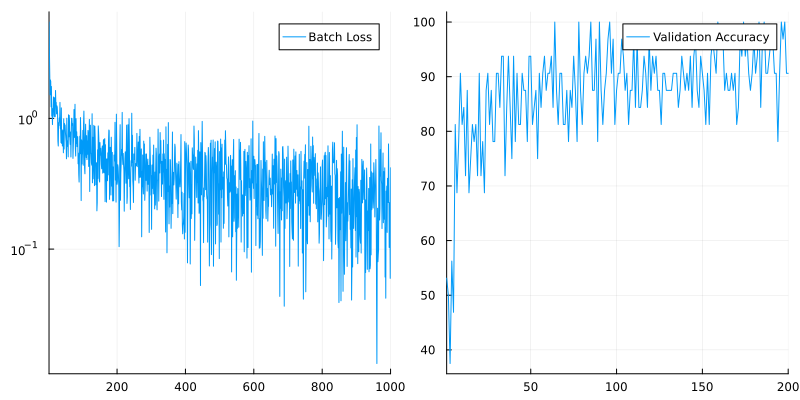

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


In [15]:
epochs = 1000

loss = 0.0

batch_size = 32
batch_losses = []
validation_accuracies = []

cross_entropy_loss(x_in, y_val) = -sum(y_val .* log.(Forward(mnist_network, x_in)))

@showprogress for epoch in 1:epochs
    batch_idx = rand((1:size(train_x, 3)), batch_size)
    
    batch_x = train_x[1:end, 1:end, batch_idx]
    batch_y = train_y[batch_idx]
    
    batch_loss = []
    
    for i in 1:batch_size
        x_in = convert(Vector{Float32}, flatten(batch_x[1:end, 1:end, i]))
        y_val = one_hot_encoding(batch_y[i])
        
        pred = Forward(mnist_network, x_in)
        loss = cross_entropy_loss(x_in, y_val)
        
        Backward!(mnist_network, cross_entropy_loss, x_in, y_val)
        
        push!(batch_loss, loss)
    end
    
    push!(batch_losses, sum(batch_loss) / length(batch_loss))
    
    if epoch % 5 == 0
        val_batch = 32
        val_batch_idx = rand((1:size(test_x, 3)), val_batch)

        test_predictions = argmax.([
                Forward(mnist_network, convert(Vector{Float32}, flatten(test_x[1:end, 1:end, idx]))) for idx in val_batch_idx
        ]) .- 1

        test_correct = test_predictions .== test_y[val_batch_idx]
        val_accuracy = 100 * sum(test_correct) / val_batch
        
        push!(validation_accuracies, val_accuracy)
              
        IJulia.clear_output(true)
        p1 = plot(batch_losses, xlims=(1, epoch), yaxis=:log, label="Batch Loss")
        p2 = plot(validation_accuracies, xlims=(1, epoch//5), label="Validation Accuracy") 
        
        plot(p1, p2, layout=(1,2), size=(800,400)) |> IJulia.display
    end
end

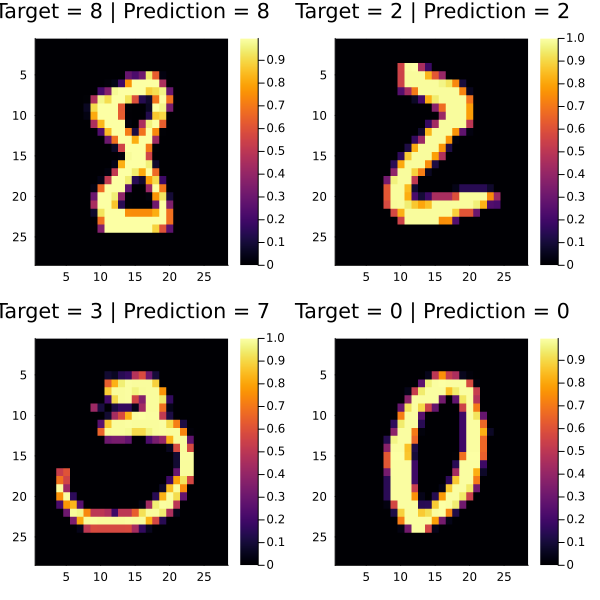

In [16]:
samps = rand(1:size(test_x, 3), 4)

test_preds = [
    Forward(mnist_network, convert(Vector{Float32}, flatten(test_x[1:end, 1:end, samp]))) for samp in samps
]

preds = [findmax(pred)[2] - 1 for pred in test_preds]

plots = []
for (i, pred) in enumerate(preds)
    temp = heatmap(
        test_x[1:end, 1:end, samps[i]]', 
        yflip=true, 
        title="Target = $(test_y[samps[i]]) | Prediction = $pred",
    )
    
    push!(plots, temp)
end

plot(plots..., layout=(2,2), size=(600,600))

In [17]:
test_predictions = argmax.([
    Forward(mnist_network, convert(Vector{Float32}, flatten(test_x[1:end, 1:end, i]))) for i in 1:size(test_x, 3)
]) .- 1

test_correct = test_predictions .== test_y

println("Accuracy: $(round(100 * sum(test_correct) / length(test_correct), digits=2))%")

Accuracy: 91.65%


# CNN Testing

In [18]:
mnist_cnn_network = CreateNetwork([
    ConvLayer((1, 8, 5), sigmoid_activation, params=Dict("Stride"=>1, "Padding"=>0)),
    PoolLayer((8, 1, 3), max, params=Dict("Stride"=>1, "Padding"=>0)),
    ConvLayer((8, 1, 5), sigmoid_activation, params=Dict("Stride"=>1, "Padding"=>0)),
    PoolLayer((1, 1, 3), max, params=Dict("Stride"=>1, "Padding"=>0)),
    DenseLayer((256, 128), sigmoid_activation),
    DenseLayer((128, 64), sigmoid_activation),
    DenseLayer((64, 10), softmax_activation)
], datatype=Float32, init_distribution=Normal())

OptimizerSetup!(mnist_cnn_network, AdamOptimizer!, step_size=0.3)

Dict{String, Any} with 10 entries:
  "biases_m"       => [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0], [0.0], …
  "biases_v"       => [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0], [0.0], …
  "optimizer"      => AdamOptimizer!
  "decay_2"        => 0.999
  "optimizer_name" => "AdamOptimizer!"
  "epsilon"        => 1.0e-8
  "weights_v"      => Array{Float64}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ;…
  "step_size"      => 0.3
  "weights_m"      => Array{Float64}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ;…
  "decay_1"        => 0.9

In [19]:
# testing forward pass
Forward(mnist_cnn_network, cat(test_x[1:end, 1:end, 1], dims=3))

10-element Vector{Float32}:
 3.7262686f-5
 5.6222094f-10
 2.4910753f-7
 7.022125f-8
 2.2938855f-6
 0.013394968
 0.9805408
 2.9544744f-10
 9.969205f-8
 0.006024287

In [ ]:
# pool layer still needs to be fixed, does not work on backwards pass
epochs = 250

batch_size = 8

batch_losses = []
validation_accuracies = []

cross_entropy_loss(x_in, y_val) = -sum(y_val .* log.(Forward(mnist_cnn_network, x_in)))

@showprogress for epoch in 1:epochs
    batch_idx = rand((1:size(train_x, 3)), batch_size)
    
    batch_x = train_x[1:end, 1:end, batch_idx]
    batch_y = train_y[batch_idx]
    
    batch_loss = []
    
    for i in 1:batch_size
        x_in = cat(batch_x[1:end, 1:end, i], dims=3)
        y_val = one_hot_encoding(batch_y[i])
        
        pred = Forward(mnist_cnn_network, x_in)
        loss = cross_entropy_loss(x_in, y_val)
        
        Backward!(mnist_cnn_network, cross_entropy_loss, x_in, y_val)
        
        push!(batch_loss, loss)
    end
    
    push!(batch_losses, sum(batch_loss) / length(batch_loss))
    
    if epoch % 5 == 0
        val_batch = 32
        val_batch_idx = rand((1:size(test_x, 3)), val_batch)

        test_predictions = argmax.([
                Forward(mnist_cnn_network, cat(test_x[1:end, 1:end, idx], dims=3)) for idx in val_batch_idx
        ]) .- 1

        test_correct = test_predictions .== test_y[val_batch_idx]
        val_accuracy = 100 * sum(test_correct) / val_batch
        
        push!(validation_accuracies, val_accuracy)
        
#         println("Epoch $epoch \tValidation accuracy: $(100 * sum(test_correct) / val_batch)%")
        
        IJulia.clear_output(true)
        p1 = plot(batch_losses, xlims=(1, epoch), yaxis=:log, label="Batch Loss")
        p2 = plot(validation_accuracies, xlims=(1, epoch//5), label="Validation Accuracy") 
        
        plot(p1, p2, layout=(1,2), size=(800,500)) |> IJulia.display
    end
end

In [ ]:
samps = rand(1:size(test_x, 3), 4)

test_preds = [
    Forward(mnist_cnn_network, [train_x[1:end, 1:end, samp]]) for samp in samps
]

preds = [findmax(pred)[2] - 1 for pred in test_preds]

plots = []
for (i, pred) in enumerate(preds)
    temp = heatmap(
        train_x[1:end, 1:end, samps[i]]', 
        yflip=true, 
        title="Target = $(train_y[samps[i]]) | Prediction = $pred",
    )
    
    push!(plots, temp)
end

plot(plots..., layout=(2,2), size=(600,600))

In [25]:
test_predictions = argmax.([
    Forward(mnist_cnn_network, cat(test_x[1:end, 1:end, i], dims=3)) for i in 1:size(test_x, 3)
]) .- 1

test_correct = test_predictions .== test_y

println("Accuracy: $(round(100 * sum(test_correct) / length(test_correct), digits=2))%")

Accuracy: 11.35%
